In [286]:
import numpy as np
from qiskit.quantum_info.operators.symplectic import SparsePauliOp
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
from bitstring import BitArray

In [287]:
m = 3                       #Number of modes
a = 3                       #Number of possible values
N = int(np.log2(a**m))+1 if (int(np.log2(a**m))+1)%2 == 0 else int(np.log2(a**m))+2    #Number of qubits for encoding

print(N)
#Random pick selection
x = np.random.randint(a**m)

bin_x = "{0:b}".format(x)
bin_x = '0'*(N-len(bin_x)) + bin_x

print(x)
print(bin_x)

6
10
001010


In [288]:
def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]

In [289]:
def all_config(size):
    all_pat = []
    for i in range(size-1):
        for j in range(size-1-i):
            for v1 in range(2):
                for v2 in range(2):
                    all_pat.append( [[1,1]]*i + bin_to_pattern(str(v1)) + [[1,1]]*j + bin_to_pattern(str(v2)) + [[1,1]]*(size-i-j-2))
    return all_pat

In [290]:
def create_specific_patterns(mode1,mode2,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(size-mode1-(mode2-mode1-1)-2) )
    return pats

In [291]:
def create_specific_patterns3(mode1,mode2,mode3,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(mode3-(mode2-mode1-1)-mode1-2) + bin_to_pattern(str(k)) + [[1,1]]*(size -mode1-(mode2-mode1-1)-(mode3-(mode2-mode1-1)-mode1-2)-3) )
    return pats

In [292]:
def overlapp(x,measurement):
    return np.prod( [np.dot(p1,p2) for p1,p2 in zip(x,measurement)] )

In [293]:
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(f,i)
    return f

In [294]:
def decomposition(mat):
    a,b,c,d = mat[0],mat[1],mat[2],mat[3]
    return 1/4 * np.array( [a+b+c+d, a+b-c-d, a-b+c-d, a-b-c+d] )

In [295]:
pat = bin_to_pattern(bin_x)
# all_pat = all_config(N)
# all_pat = create_specific_patterns(0,2,N) + create_specific_patterns(0,3,N) + create_specific_patterns(0,4,N) + create_specific_patterns(0,5,N) + create_specific_patterns(1,3,N) + create_specific_patterns(1,4,N) + create_specific_patterns(1,5,N) + create_specific_patterns(2,4,N) + create_specific_patterns(2,5,N) + create_specific_patterns(3,5,N)
all_pat = create_specific_patterns3(0,1,2,N)+create_specific_patterns3(0,1,3,N) + create_specific_patterns3(0,1,4,N) + create_specific_patterns3(0,1,5,N) + create_specific_patterns3(1,2,3,N) + create_specific_patterns3(1,2,5,N) + create_specific_patterns3(2,4,5,N)
print(len(all_pat))

y = np.matrix([ overlapp(pat,p) for p in all_pat]).T

A = np.matrix([ dev_pattern(p) for p in all_pat])

print( np.argmax(A.T * y))
print( (A.T*y).shape)

56
10
(64, 1)


In [296]:
# I, s1, s2, s3, s4, s1s2, s2s3, s3s4

#['IIII', 'IIZI', 'IIIZ', 'IIZZ', 'ZIII', 'ZIZI', 'ZIIZ', 'ZIZZ', 'IZII', 'IZZI', 'IZIZ', 'IZZZ', 'ZZII', 'ZZZI', 'ZZIZ', 'ZZZZ']

H_ops = []

for p,yi in zip(all_pat,y):

    ops = []
    for i in range(0,len(p),2):
        coefs = decomposition(dev_pattern([p[i],p[i+1]]))
        ops.append(SparsePauliOp(["II","ZI","IZ","ZZ"],coefs))
    op = ops[0]
    for i in range(1,len(ops)):
        op = op.tensor(ops[i])
    H_ops.append(op * yi[0,0])

#Recover paulis list
i=0
while len(H_ops[i].paulis)<=1:
    i+=1
paulis_idx = H_ops[i].paulis

#Recover coeffs of H
H = np.real(np.sum([ op.coeffs for op in H_ops ]))

for pstring,coef in zip(paulis_idx,H):
    print(pstring,coef)

# test = SparsePauliOp(paulis_idx,H)
# print(np.real(np.diag(test.to_matrix())))

IIIIII 0.875
IIIIZI -0.25
IIIIIZ 0.375
IIIIZZ -0.125
IIZIII -0.5
IIZIZI 0.125
IIZIIZ -0.25
IIZIZZ 0.125
IIIZII 0.25
IIIZZI 0.0
IIIZIZ 0.0
IIIZZZ 0.0
IIZZII -0.125
IIZZZI 0.0
IIZZIZ 0.0
IIZZZZ 0.0
ZIIIII 0.5
ZIIIZI -0.125
ZIIIIZ 0.125
ZIIIZZ 0.0
ZIZIII -0.125
ZIZIZI 0.0
ZIZIIZ 0.0
ZIZIZZ 0.0
ZIIZII 0.125
ZIIZZI 0.0
ZIIZIZ 0.0
ZIIZZZ 0.0
ZIZZII 0.0
ZIZZZI 0.0
ZIZZIZ 0.0
ZIZZZZ 0.0
IZIIII 0.75
IZIIZI -0.125
IZIIIZ 0.25
IZIIZZ 0.0
IZZIII -0.375
IZZIZI 0.0
IZZIIZ -0.125
IZZIZZ 0.0
IZIZII 0.25
IZIZZI 0.0
IZIZIZ 0.0
IZIZZZ 0.0
IZZZII -0.125
IZZZZI 0.0
IZZZIZ 0.0
IZZZZZ 0.0
ZZIIII 0.5
ZZIIZI -0.125
ZZIIIZ 0.125
ZZIIZZ 0.0
ZZZIII -0.125
ZZZIZI 0.0
ZZZIIZ 0.0
ZZZIZZ 0.0
ZZIZII 0.125
ZZIZZI 0.0
ZZIZIZ 0.0
ZZIZZZ 0.0
ZZZZII 0.0
ZZZZZI 0.0
ZZZZIZ 0.0
ZZZZZZ 0.0


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [297]:
def paulis_to_gates(pauli_string):
    idx = [i for i,s in enumerate(pauli_string) if s=='Z']
    # if len(idx)==2 and idx[1] == idx[0]+1:
    #     return []
    return idx

In [298]:
nqubits = N

qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)

gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pstring,coef in zip(paulis_idx,H):
    if coef!=0:
        idx = paulis_to_gates(str(pstring))
        print(idx,coef)
        if len(idx)==1:
            qc_p.rz(2*gamma*coef,idx[0])
        if len(idx)==2:
            qc_p.rzz(2*gamma*coef,idx[0],idx[1])
        if len(idx)==3:
            qc_p.cnot(idx[0],idx[1])
            qc_p.cnot(idx[1],idx[2])
            qc_p.rz(2*gamma*coef,idx[2])
            qc_p.cnot(idx[1],idx[2])
            qc_p.cnot(idx[0],idx[1])
    
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

[] 0.875
[4] -0.25
[5] 0.375
[4, 5] -0.125
[2] -0.5
[2, 4] 0.125
[2, 5] -0.25
[2, 4, 5] 0.125
[3] 0.25
[2, 3] -0.125
[0] 0.5
[0, 4] -0.125
[0, 5] 0.125
[0, 2] -0.125
[0, 3] 0.125
[1] 0.75
[1, 4] -0.125
[1, 5] 0.25
[1, 2] -0.375
[1, 2, 5] -0.125
[1, 3] 0.25
[1, 2, 3] -0.125
[0, 1] 0.5
[0, 1, 4] -0.125
[0, 1, 5] 0.125
[0, 1, 2] -0.125
[0, 1, 3] 0.125


global phase: -1.0*$\gamma$
     ┌─────────┐┌────────────────┐ ┌──────────────────┐     »
q_0: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├─┤ U1(1.0*$\gamma$) ├─────»
     ├─────────┤├────────────────┤ ├──────────────────┤     »
q_1: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├─┤ U1(1.5*$\gamma$) ├─────»
     ├─────────┤├────────────────┤┌┴──────────────────┤     »
q_2: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├┤ U1(-1.0*$\gamma$) ├─────»
     ├─────────┤├────────────────┤└┬──────────────────┤     »
q_3: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├─┤ U1(0.5*$\gamma$) ├─────»
     ├─────────┤├────────────────┤┌┴──────────────────┤     »
q_4: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├┤ U1(-0.5*$\gamma$) ├──■──»
     ├─────────┤├────────────────┤├───────────────────┤┌─┴─┐»
q_5: ┤ U2(0,π) ├┤ R(2*$\beta$,0) ├┤ U1(0.75*$\gamma$) ├┤ X ├»
     └─────────┘└────────────────┘└───────────────────┘└───┘»
«                                                                    »
«q_0: ───────────────────────────────────────────────────────────────»
«                                                                    »
«q_1: ───────────────────────────────────────────────────────────────»
«                                                                    »
«q_2: ─────────────────────────────■─────────────────────────■────■──»
«                                  │                         │    │  »
«q_3: ─────────────────────────────┼─────────────────────────┼────┼──»
«                                ┌─┴─┐┌───────────────────┐┌─┴─┐  │  »
«q_4: ────────────────────────■──┤ X ├┤ Rz(0.25*$\gamma$) ├┤ X ├──┼──»
«     ┌────────────────────┐┌─┴─┐└───┘└───────────────────┘└───┘┌─┴─┐»
«q_5: ┤ Rz(-0.25*$\gamma$) ├┤ X ├───────────────────────────────┤ X ├»
«     └────────────────────┘└───┘                               └───┘»
«                                                                             »
«q_0: ─────────────────────────────────────────────────────────────────────■──»
«                                                                          │  »
«q_1: ─────────────────────────────────────────────────────────────────────┼──»
«                                                                          │  »
«q_2: ───────────────────────■────■───────────────────────────────────■────┼──»
«                            │    │                                   │    │  »
«q_3: ───────────────────────┼────┼───────────────────────────────────┼────┼──»
«                            │  ┌─┴─┐                               ┌─┴─┐┌─┴─┐»
«q_4: ───────────────────────┼──┤ X ├──■─────────────────────────■──┤ X ├┤ X ├»
«     ┌───────────────────┐┌─┴─┐└───┘┌─┴─┐┌───────────────────┐┌─┴─┐└───┘└───┘»
«q_5: ┤ Rz(-0.5*$\gamma$) ├┤ X ├─────┤ X ├┤ U1(0.25*$\gamma$) ├┤ X ├──────────»
«     └───────────────────┘└───┘     └───┘└───────────────────┘└───┘          »
«                                                                »
«q_0: ───────────────────────────────────────────────────■────■──»
«                                                        │    │  »
«q_1: ───────────────────────────────────────────────────┼────┼──»
«                                                        │    │  »
«q_2: ──────────■───────────────────────────────────■────┼────┼──»
«             ┌─┴─┐         ┌────────────────────┐┌─┴─┐  │    │  »
«q_3: ────────┤ X ├─────────┤ Rz(-0.25*$\gamma$) ├┤ X ├──┼────┼──»
«     ┌───────┴───┴────────┐└────────────────────┘└───┘┌─┴─┐  │  »
«q_4: ┤ Rz(-0.25*$\gamma$) ├───────────────────────────┤ X ├──┼──»
«     └────────────────────┘                           └───┘┌─┴─┐»
«q_5: ──────────────────────────────────────────────────────┤ X ├»
«                                                           └───┘»
«                                                                    »
«q_0: ──────────────────────────────────────────────────■────■───────»
«                                                       │    │       »
«q_1: ──────────■──────────────────────────────────■────┼────┼────■──»
«               │                               

In [299]:
def obj_func(z):
    v = BitArray(bin='0'+z).int
    return (A.T[v] * y)[0,0]


def compute_expectation(counts):
        
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = -obj_func(bitstring)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def create_qaoa_circ(theta):

    nqubits = N
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

        for pstring,coef in zip(paulis_idx,H):
            if coef!=0:
                idx = paulis_to_gates(str(pstring))
                if len(idx)==1:
                    qc.rz(2*gamma[irep]*coef,idx[0])
                if len(idx)==2:
                    qc.rzz(2*gamma[irep]*coef,idx[0],idx[1])
                if len(idx)==3:
                    qc.cnot(idx[0],idx[1])
                    qc.cnot(idx[1],idx[2])
                    qc.rz(2*gamma[irep]*coef,idx[2])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[0],idx[1])

    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(shots=512):
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts)
    
    return execute_circ

In [300]:
expectation = get_expectation()

res = minimize(expectation, 
                      np.ones(50), 
                      method='COBYLA')
res

     fun: -3.427734375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 759
  status: 1
 success: True
       x: array([0.97971234, 0.89766767, 1.0087261 , 1.20366278, 0.89157505,
       0.96474261, 1.2239723 , 0.89782196, 0.8203987 , 1.28841869,
       1.01330124, 1.00781866, 2.00986015, 1.18625591, 2.21107011,
       1.05647482, 0.92258357, 2.0351271 , 0.9291308 , 1.11683081,
       0.95843993, 1.17738285, 0.7939588 , 1.28862651, 1.03391808,
       1.026712  , 1.42103173, 1.55204134, 0.91446538, 1.01616509,
       1.08459863, 1.04960118, 1.29109928, 1.19095653, 0.99526544,
       0.9968914 , 0.77896985, 1.15284205, 0.83207523, 0.83056794,
       0.86717935, 1.09675216, 1.0184734 , 1.06741595, 1.02935123,
       0.82147593, 0.97953132, 0.92738793, 1.09239297, 1.04378508])

001010


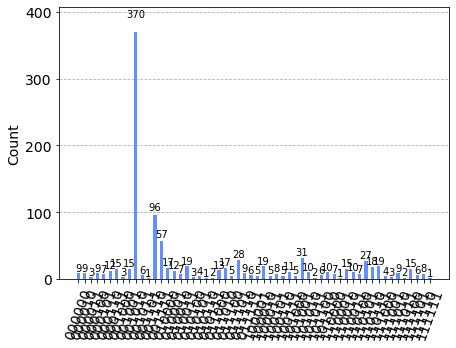

In [302]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

print( list(counts.keys())[np.argmax(list(counts.values()))])

plot_histogram(counts)